# Mount Google Drive

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

Mounted at /gdrive
/gdrive/My Drive/[2024-2025] AN2DL/Homework 2


# Import libraries

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.preprocessing.image import apply_affine_transform

import math
import random
import matplotlib.pyplot as plt

import copy
from sklearn.model_selection import train_test_split

In [ ]:
!pip install keras-cv
import keras_cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 30.7 MB/s eta 0:00:00


# Load data

In [ ]:
data_no_aliens = np.load("No_aliens_float64.npz")
X_train_val = data_no_aliens['arr_0']
y_train_val = data_no_aliens['arr_1']

In [ ]:
big_rocks = [31, 56, 57, 140, 145, 158, 162, 241, 326, 382, 406, 443, 470, 475, 572, 614, 728, 737, 739, 813, 832, 849, 856, 872, 922, 985, 1026, 1030, 1125, 1162, 1168, 1169, 1182, 1266, 1337, 1443, 1456, 1475, 1491, 1526, 1527, 1544, 1576, 1633, 1684, 1781, 1792, 1883, 1919, 2014, 2055, 2086, 2102, 2111, 2156, 2193, 2199, 2253, 2331, 2351, 2412, 2417, 2498]

# Find the images containing big rocks in the dataset
if len(big_rocks) == 0:
  for i in range(len(X_train_val)):
    done = False
    for j in range(len(X_train_val[0])):
      for k in range(len(X_train_val[0][0])):
        if y_train_val[i][j][k] == 4:
          big_rocks.append(i)
          done = True
          break
      if done:
        break

print(len(big_rocks))
print(" ".join(map(str,big_rocks)))

# Find the images not containing big rocks in the dataset
without_big_rocks = [i for i in range(len(X_train_val)) if i not in big_rocks]
print(len(without_big_rocks))

63
31 56 57 140 145 158 162 241 326 382 406 443 470 475 572 614 728 737 739 813 832 849 856 872 922 985 1026 1030 1125 1162 1168 1169 1182 1266 1337 1443 1456 1475 1491 1526 1527 1544 1576 1633 1684 1781 1792 1883 1919 2014 2055 2086 2102 2111 2156 2193 2199 2253 2331 2351 2412 2417 2498
2442


In [ ]:
# Print the big rocks and their labels
for i in range((len(big_rocks)+1)//2):
  idx = big_rocks[2*i]

  if i == (len(big_rocks)+1)//2 - 1:
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))
  else:
    fig, axes = plt.subplots(1, 4, figsize=(20, 20))

  axes[0].imshow(np.squeeze(X_train_val[idx]), cmap = 'grey',vmin=0, vmax=255)
  axes[1].imshow(np.squeeze(y_train_val[idx]), cmap = 'nipy_spectral',vmin=0, vmax=4)
  axes[0].set_title(f'{idx}', y=1.0, fontsize=22, pad=-24, color='white')
  axes[1].set_title(f'{idx}', y=1.0, fontsize=22, pad=-24, color='white')
  axes[0].axis('off')
  axes[1].axis('off')

  if i == (len(big_rocks)+1)//2 - 1:
    break

  idx = big_rocks[2*i+1]
  axes[2].imshow(np.squeeze(X_train_val[idx]), cmap = 'grey',vmin=0, vmax=255)
  axes[3].imshow(np.squeeze(y_train_val[idx]), cmap = 'nipy_spectral',vmin=0, vmax=4)
  axes[2].set_title(f'{idx}', y=1.0, fontsize=22, pad=-24, color='white')
  axes[3].set_title(f'{idx}', y=1.0, fontsize=22, pad=-24, color='white')
  axes[2].axis('off')
  axes[3].axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Find big rocks that are reasonably big
good_big_rocks = [31, 56, 140, 145, 158, 162, 241, 326, 382, 406, 443, 470, 475, 572, 614, 728, 737, 739, 813, 832, 849, 872, 985, 1026, 1030, 1125, 1162, 1182, 1266, 1337, 1443, 1456, 1526, 1527, 1544, 1576, 1633, 1781, 1792, 1883, 1919, 2014, 2055, 2086, 2111, 2193, 2199, 2253, 2331, 2412, 2417]
print(len(good_big_rocks))

51


# Apply distortion

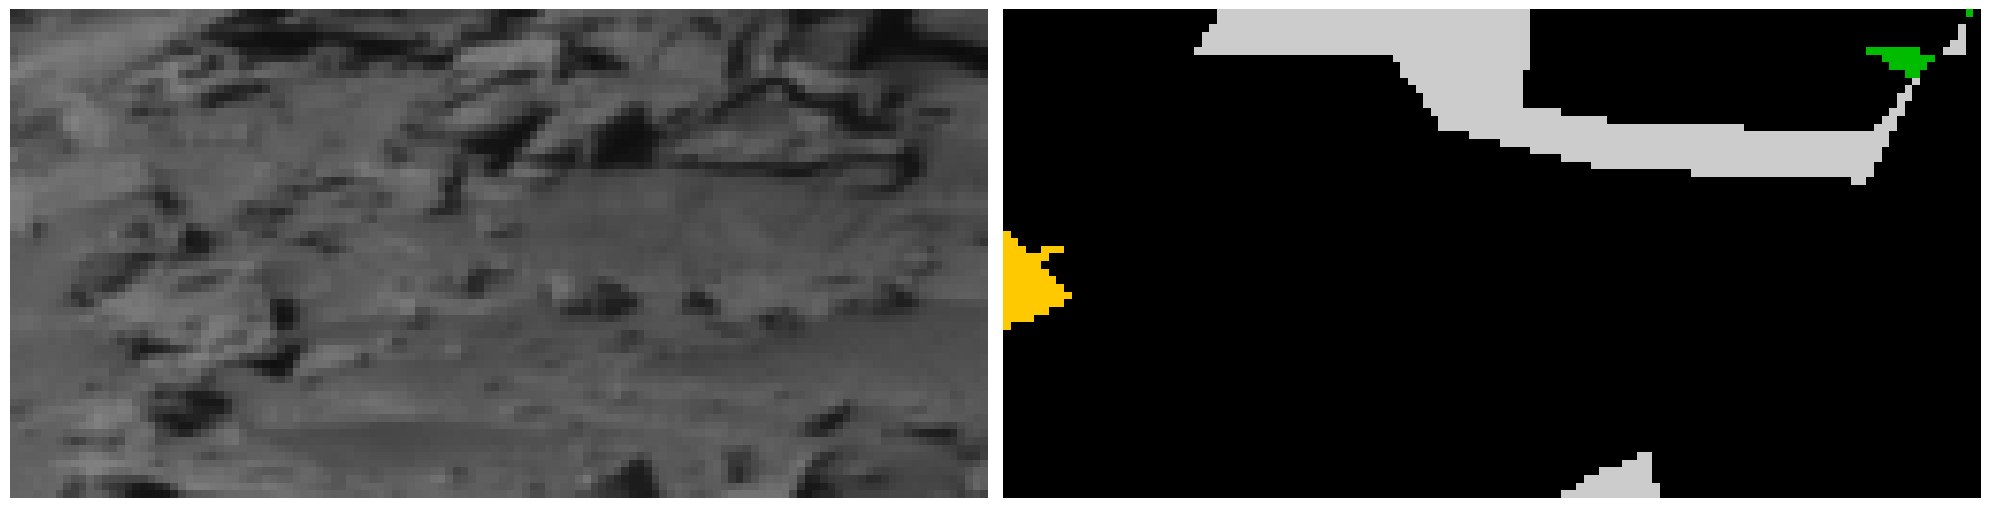

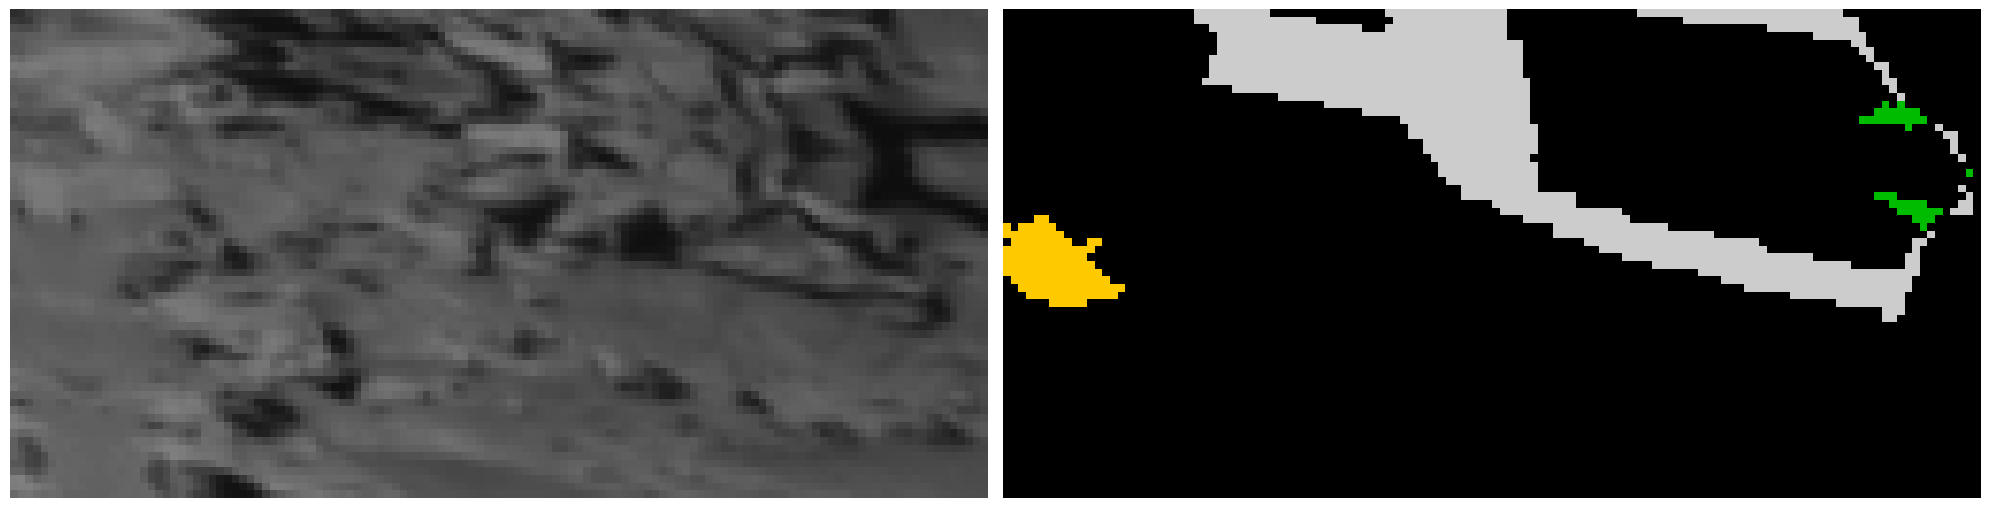

In [ ]:
# Apply distortions based on a transformation matrix
def apply_transformation(image, label):
  tot_rock_pixels = 0
  new_tot_rock_pixels = 0

  # Count the number of pixels originally covered by big rocks
  for i in range(len(label)):
    for j in range(len(label[0])):
      if label[i][j] == 4:
        tot_rock_pixels += 1

  image = tf.cast(image[..., np.newaxis], tf.uint8)
  label = tf.cast(label[..., np.newaxis], tf.uint8)

  while tot_rock_pixels > new_tot_rock_pixels:
    transformation_matrix = [1, 0, 0, 0, 1, 0, 0, 0]
    rnd = [random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)]

    # translation: [1, 0, tx, 0, 1, ty, 0, 0]
    if rnd[0] > 0.5:
      #print("trans")
      trans_std_dev = 0.05
      normal = np.random.normal(loc=0, scale=trans_std_dev, size=2)
      transformation_matrix[2] += normal[0]
      transformation_matrix[5] += normal[1]

    # scaling: [sx, 0, 0, 0, sy, 0, 0, 0]
    elif rnd[1] > 0.5:
      #print("scale")
      scale_std_dev = 0.1
      normal = np.random.normal(loc=0, scale=scale_std_dev, size=2)

      # Don't let the scale factors be too far off each others
      normal[1] = np.clip(normal[1], normal[0] - 0.2, normal[1] + 0.2)

      # Slight bias towards scaling down (big rocks are often at the edges)
      bias = 0.1
      normal[0] = np.clip(normal[0], -0.25 - bias, 0.25 - bias) + bias
      normal[1] = np.clip(normal[1], -0.25 - bias, 0.25 - bias) + bias
      transformation_matrix[0] *= (1 + normal[0])
      transformation_matrix[4] *= (1 + normal[1])

    # rotating: [math.cos(theta), -math.sin(theta), 0, math.sin(theta), math.cos(theta), 0, 0, 0]
    elif rnd[2] > 0.5:
      #print("rot")
      rot_std_dev = 0.25
      normal = np.random.normal(loc=0, scale=rot_std_dev, size=1)
      theta = math.radians(normal[0] * 45)
      theta = np.clip(theta, -math.pi/2, math.pi/2)
      transformation_matrix[0] += math.cos(theta) - 1
      transformation_matrix[1] -= math.sin(theta)
      transformation_matrix[3] += math.sin(theta)
      transformation_matrix[4] += math.cos(theta) - 1

    # shearing: [1, shx, 0, shy, 1, 0, 0, 0]
    if rnd[3] > 0.5:
      #print("shear")
      sh_std_dev = 0.1
      normal = np.random.normal(loc=0, scale=sh_std_dev, size=2)
      transformation_matrix[1] += normal[0]
      transformation_matrix[3] += normal[1]

    # Reshape to 3x3 matrix
    transformation_matrix = tf.convert_to_tensor(transformation_matrix, dtype=tf.float32)
    transformation_matrix = tf.reshape(transformation_matrix, [8])

    # Apply distortion on the labels
    distorted_label = tf.raw_ops.ImageProjectiveTransformV3(
        images=tf.expand_dims(label, 0),
        transforms=tf.expand_dims(transformation_matrix, 0),
        output_shape=[64, 128],
        interpolation="NEAREST",
        fill_mode = "REFLECT",
        fill_value=0.0
    )

    new_tot_rock_pixels = tf.reduce_sum(tf.cast(distorted_label[..., 0] == 4, tf.int32))

  # Apply transformation on the images
  distorted_image = tf.raw_ops.ImageProjectiveTransformV3(
      images=tf.expand_dims(image, 0),
      transforms=tf.expand_dims(transformation_matrix, 0),
      output_shape=[64, 128],
      interpolation="BILINEAR",
      fill_mode = "REFLECT",
      fill_value=0.0
  )

  distorted_image = tf.cast(distorted_image[..., 0], tf.uint8)
  distorted_label = tf.cast(distorted_label[..., 0], tf.uint8)
  return distorted_image, distorted_label

# Example image
i = 6
image = X_train_val[good_big_rocks[i]]
label = y_train_val[good_big_rocks[i]]

distorted_image, distorted_label = apply_transformation(image, label)

# Display the distorted image
fig, axes = plt.subplots(1, 2, figsize=(20, 20))
axes[0].imshow(np.squeeze(image), cmap = 'grey',vmin=0, vmax=255)
axes[1].imshow(np.squeeze(label), cmap = 'nipy_spectral',vmin=0, vmax=4)
axes[0].axis('off')
axes[1].axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(20, 20))
axes[0].imshow(np.squeeze(distorted_image), cmap = 'grey',vmin=0, vmax=255)
axes[1].imshow(np.squeeze(distorted_label), cmap = 'nipy_spectral',vmin=0, vmax=4)
axes[0].axis('off')
axes[1].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Split training and validation data
X_train, X_val, y_train, y_val = train_test_split(X_train_val[without_big_rocks], y_train_val[without_big_rocks], test_size = 0.1)

# Reserve some rocks for the validation set
val_rocks = [big_rocks[i] for i in range(0, 6)]
train_rocks = [big_rocks[i] for i in range(6, len(big_rocks))]

# Augment the training set
train_augmented = []
train_label_augmented = []
for i in range(len(train_rocks)):
  for j in range(0, 10):
    ta, la = apply_transformation(copy.copy(X_train_val[train_rocks[i]]), copy.copy(y_train_val[train_rocks[i]]))
    train_augmented.append(ta)
    train_label_augmented.append(la)

# Append the augmented samples
train_augmented = [np.squeeze(tf.convert_to_tensor(ta).numpy()) for ta in train_augmented]
train_label_augmented = [np.squeeze(tf.convert_to_tensor(la).numpy()) for la in train_label_augmented]
X_train = np.concatenate([X_train, train_augmented])
y_train = np.concatenate([y_train, train_label_augmented])

# Put the original rock pictures back in the dataset
for i in range(len(big_rocks)):
  if(big_rocks[i] not in val_rocks):
    X_train = np.append(X_train, np.expand_dims(X_train_val[big_rocks[i]], axis=0), axis=0)
    y_train = np.append(y_train, np.expand_dims(y_train_val[big_rocks[i]], axis = 0), axis = 0)
  else:
    X_val = np.append(X_val, np.expand_dims(X_train_val[big_rocks[i]], axis=0), axis=0)
    y_val = np.append(y_val, np.expand_dims(y_train_val[big_rocks[i]], axis = 0), axis = 0)

In [ ]:
# Cast datasets to the uint8 data type
X_train = tf.cast(X_train, tf.uint8)
y_train = tf.cast(y_train, tf.uint8)
X_val = tf.cast(X_val, tf.uint8)
y_val = tf.cast(y_val, tf.uint8)

# Shuffle the datasets
shuffled_indices1 = tf.random.shuffle(tf.range(tf.shape(X_train)[0]))
shuffled_indices2 = tf.random.shuffle(tf.range(tf.shape(X_val)[0]))
X_train = tf.gather(X_train, shuffled_indices1)
y_train = tf.gather(y_train, shuffled_indices1)
X_val = tf.gather(X_val, shuffled_indices2)
y_val = tf.gather(y_val, shuffled_indices2)

# Visualize the augmented data

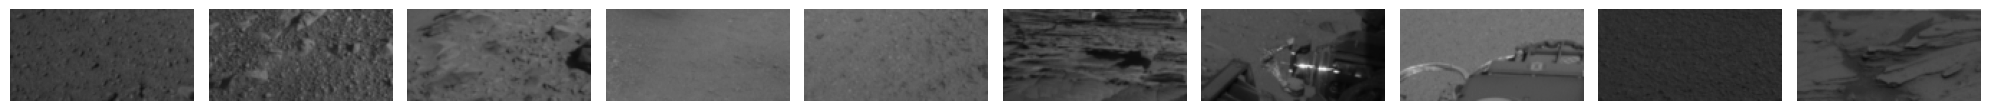

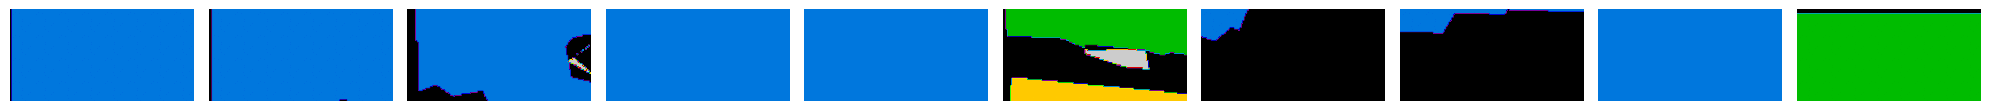

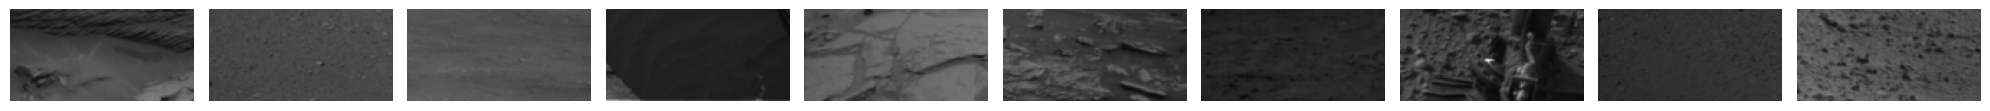

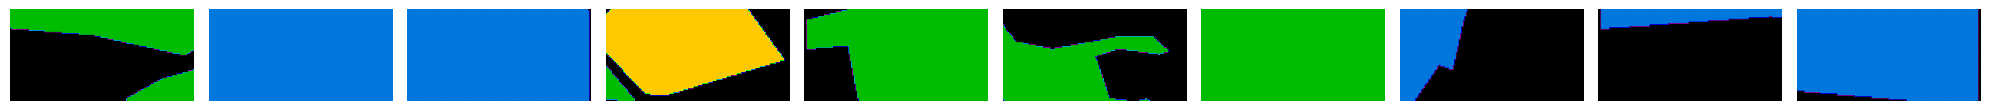

In [ ]:
# Display a sample of images from the new training dataset
num_img = 10
random_indices = random.sample(range(len(X_train)), num_img)

fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(X_train[idx]),cmap = 'grey',vmin=0, vmax=255)
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(y_train[idx]), cmap = 'nipy_spectral',vmin=0, vmax=4)
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

# Display a sample of images from the new validation dataset
num_img = 10
random_indices = random.sample(range(len(X_val)), num_img)

fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(X_val[idx]),cmap = 'grey',vmin=0, vmax=255)
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(y_val[idx]), cmap = 'nipy_spectral',vmin=0, vmax=4)
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

# Save the new data

In [ ]:
# Save data to a file
np.savez('DistortedRocks', X_train, y_train, X_val, y_val)